In [177]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt

plt.style.use("recovered_style.mplstyle") # plot style
from typing import Literal # function definition
import itertools # use combination function
import string # get letters A, B, etc
from sklearn.metrics import accuracy_score, roc_auc_score

In [ ]:
#======== Step 1 load data frame and target vector ========
probs_df = pd.read_csv('test_df.csv')

# check if probs_df has more than 2 columns
if probs_df.shape[1] < 3:
    print("The data frame should have more than 2 columns!")
    raise SystemExit

# load target vector
y_true = pd.read_csv('test_ytrue.csv')

# check if probs_df and y_true have same number of rows
if probs_df.shape[0] != y_true.shape[0]:
    print("The data frame and the target vector don't have same number of rows!")
    raise SystemExit 

,A,B,C,D,E
0,0.333397,0.378896,0.421560,0.309491,1.262137e-03
1,0.569227,0.844793,0.999568,0.833341,2.195689e-08
2,0.012746,0.105379,0.005150,0.007349,5.850156e-03


In [72]:
perf_metric = 'auroc'

In [118]:
def compute_performance(df, perf_metric: Literal["accuracy", "auroc"], y_true, score = True):
    # the reason that we need to distinguish score or rank when computing performance is
    # for ranks, we covnert to values between 0 and 1 and then compare to 0.5
    # since rank 1 is the highest and will be converted to 0, 
    # converted values less than 0.5 should have label 1.
    
    if perf_metric not in ("accuracy", "auroc"):
        raise ValueError("Performance metric we support now is 'accuracy' or 'auroc'!")
    if score:
        if perf_metric == 'accuracy':
            acc_dict = {}
            for col in df.columns:
                y_binary = (df[col] >= 0.5).astype(int)
                acc_dict[col] = accuracy_score(y_true, y_binary)
            perf = pd.Series(acc_dict, name = 'accuracy')
        elif perf_metric == 'auroc':
            auc_dict = {}
            for col in df.columns:
                auc_dict[col] = roc_auc_score(y_true, df[col])
                
            perf = pd.Series(auc_dict, name = 'auroc')
    else: 
        df_n = (df - df.min()) / (df.max() - df.min()) # normalize ranks to [0, 1]

        if perf_metric == 'accuracy':
            acc_dict = {}
            for col in df_n.columns:
                y_binary = (df_n[col] <= 0.5).astype(int)
                acc_dict[col] = accuracy_score(y_true, y_binary)
            perf = pd.Series(acc_dict, name = 'accuracy')
        
        elif perf_metric == 'auroc': # here df or df_n is fine because auroc is based on ranks
            # normalization doesn't change ranks
            auc_dict = {}
            for col in df.columns:
                auc_dict[col] = 1- roc_auc_score(y_true, df[col]) # auc is based on ascending order
                
            perf = pd.Series(auc_dict, name = 'auroc')
        
    return perf

In [142]:
#======== Step 2 get performance for base models ========
# change column names to letters, such as A, B, C, etc
n_col = probs_df.shape[1] # get number of columns
probs_df.columns = list(string.ascii_uppercase[:n_col])

# get performance for base models: accuracy or auroc
base_perf = compute_performance(probs_df, perf_metric, y_true, score=True)
    
base_perf

A    0.8945
B    0.8835
C    0.9000
D    0.9380
E    0.9335
Name: accuracy, dtype: float64

In [48]:
def normalization(df: pd.DataFrame) -> pd.DataFrame:    
    minv = df.min(axis = 0)
    maxv = df.max(axis = 0)
    denom = (maxv - minv).replace(0, np.nan)  # Avoid division by zero
    if denom.isna().any():
        print("At leaset one column of the data frame is constant!")

    scaled = (df - minv) / denom
    scaled = scaled.fillna(0.0)
    
    return scaled


def compute_cd_ds(df):
    # Step 1: Scale each column to [0,1] (min–max scaling)
    minv = df.min(axis = 0)
    maxv = df.max(axis = 0)
    denom = (maxv - minv).replace(0, np.nan)  # Avoid division by zero
    if denom.isna().any():
        print("At leaset one column of the data frame is constant!")

    scaled = (df - minv) / denom
    scaled = scaled.fillna(0.0)

    # Step 2: Sort each column descending independently, which is rank-score function
    df_1 = pd.DataFrame({
        c: scaled[c].sort_values(ascending=False).reset_index(drop=True)
        for c in scaled.columns
    })

    # Step 3: Compute CD for each pair (root mean squared difference)
    pairs = list(itertools.combinations(df_1.columns, 2))
    cds = []
    pair_labels = []
    for a, b in pairs:
        x = df_1[a].to_numpy()
        y = df_1[b].to_numpy()
        x_size = x.size
        if x_size == 1:
            x_size = 2 # avoid x_size -1 = 0
        cd = np.sqrt(np.sum( (x - y) ** 2 )/ (x_size - 1))
        cds.append(cd)
        pair_labels.append((a, b))  # tuple for easier filtering later for calcualting ds
    df_2 = pd.DataFrame({"CD": cds}, index=pd.MultiIndex.from_tuples(pair_labels, names=["Col1", "Col2"]))

    # Step 4: For each column, compute ds = average CD over all pairs containing it
    ds_vals = {}
    for col in df_1.columns:
        mask = (df_2.index.get_level_values(0) == col) | (df_2.index.get_level_values(1) == col)
        ds_vals[col] = df_2.loc[mask, "CD"].mean()
    df_3 = pd.DataFrame({"ds": pd.Series(ds_vals)})

    return df_1, df_2, df_3


def average_score_combination(df):
    scoring_sys = {}

    # Generate combinations of 2 to n columns (n-> number of columns in df)
    for r in range(2, df.shape[1]+1):
        for cols in itertools.combinations(df.columns, r):
            combo_name = ''.join(cols)
            avg_scores = df[list(cols)].mean(axis=1)
            scoring_sys[combo_name] = avg_scores

    # Convert to DataFrame
    score_df = pd.DataFrame(scoring_sys, index=df.index)
    return score_df


def average_rank_combination(df):
    # only changed one place from average score combination
    # add rank(ascending = False)
    scoring_sys = {}

    # Generate combinations of 2 to (n+1) columns (n-> number of columns in df)
    for r in range(2, df.shape[1]+1):
        for cols in itertools.combinations(df.columns, r):
            combo_name = ''.join(cols)
            avg_scores = df[list(cols)].rank(ascending = False).mean(axis=1)
            scoring_sys[combo_name] = avg_scores

    # Convert to DataFrame
    score_df = pd.DataFrame(scoring_sys, index=df.index)
    return score_df


def weighted_score_combination_by_ds(df):
    scoring_sys = {}

    # Generate combinations of 2 to (n+1) columns (n-> number of columns in df)
    for r in range(2, df.shape[1]+1):
        for cols in itertools.combinations(df.columns, r):
            combo_name = ''.join(cols)
            df_subset = df[list(cols)]
            _, _, df_weights = compute_cd_ds(df_subset) # only need diversity strength
            weights = df_weights.loc[df_subset.columns, 'ds'] # weights is pd.Series here
            weights = weights/sum(weights)
            weighted_scores = df_subset.mul(weights, axis = 1).sum(axis = 1)
            scoring_sys[combo_name] = weighted_scores

    # Convert to DataFrame
    score_df = pd.DataFrame(scoring_sys, index=df.index)
    return score_df


def weighted_rank_combination_by_ds(df):
    # only changed two places from weighted score combination
    # add rank(ascending = False)
    scoring_sys = {}

    # Generate combinations of 2 to (n+1) columns (n-> number of columns in df)
    for r in range(2, df.shape[1]+1):
        for cols in itertools.combinations(df.columns, r):
            combo_name = ''.join(cols)
            df_subset = df[list(cols)]
            _, _, df_weights = compute_cd_ds(df_subset)
            weights = df_weights.loc[df_subset.columns, 'ds'] # weights is pd.Series here
            weights = weights/sum(weights)
            weighted_scores = df_subset.rank(ascending = False).mul(weights, axis = 1).sum(axis = 1) # pd.Series
            scoring_sys[combo_name] = weighted_scores

    # Convert to DataFrame
    score_df = pd.DataFrame(scoring_sys, index=df.index)
    return score_df

In [ ]:
#======== Step 3 combine models using CFA ========
# use CFA to combine them (4 types of combination: ASC, ARC, WSCDS, WRCDS)
df_asc = average_score_combination(probs_df)
df_arc = average_rank_combination(probs_df)
df_wscds = weighted_score_combination_by_ds(probs_df)
df_wrcds = weighted_rank_combination_by_ds(probs_df)

In [137]:
perf_metric = "accuracy"

In [ ]:
#======== Step 4 compute perforomance for combined models ========
perf_asc = compute_performance(df_asc, perf_metric, y_true, score = True)
perf_arc = compute_performance(df_arc, perf_metric, y_true, score = False)
perf_wscds = compute_performance(df_wscds, perf_metric, y_true, score = True)
perf_wrcds = compute_performance(df_wrcds, perf_metric, y_true, score = False)

# put all performance together by index
combined_df = pd.concat([perf_asc, perf_wscds, perf_arc, perf_wrcds], axis = 1, keys = ['asc', 'wscds', 'arc', 'wrcds'])


#======== Step 5 put base and combined performance together ========
base_block = pd.DataFrame(index=base_perf.index, columns=combined_df.columns)
for col in combined_df.columns:
    base_block[col] = base_perf

# Put base rows before df rows
fusion_df = pd.concat([base_block, combined_df], axis=0)

,asc,wscds,arc,wrcds
AB,0.8955,0.8955,0.8910,0.8910
AC,0.8990,0.8990,0.8980,0.8980
AD,0.9170,0.9170,0.9175,0.9175
AE,0.9340,0.9340,0.9315,0.9315
BC,0.8990,0.8990,0.8955,0.8955
BD,0.9155,0.9155,0.9135,0.9135
BE,0.9300,0.9300,0.9230,0.9230
CD,0.9200,0.9200,0.9215,0.9215
CE,0.9370,0.9370,0.9360,0.9360
DE,0.9460,0.9460,0.9460,0.9460


In [ ]:
def performance_plot(
    fusion_df,
    sort_col="asc",                  # sort within each group by this column
    draw_cols=("asc", "wscds", "arc", "wrcds"),  # columns to draw lines for
    palette=None, markers=None,
    figsize=(10, 4),
    ylabel="Accuracy", xlabel="CFA models",
):

    # compute number of letters for index, so we can sort within each group with same number of letters
    f = fusion_df.copy()
    f["k"] = f.index.to_series().astype(str).str.len()
    base_perf = f.loc[f['k'] == 1, :].drop(columns = ['k'], axis = 1)

    # sort by group k then by sort_col within group
    f = f.sort_values(["k", sort_col], ascending=[True, True])

    # ---------- palette/markers ----------
    if palette is None:
        palette = ['#B368FF', "#223deca6", '#FF8C00', "#0DA86C"]
    if markers is None:
        markers = ['x', '^', 's', 'o']

    # ---------- set x as numeric positions ----------
    x = np.arange(len(f))
    labels = f.index.astype(str).tolist()

    fig, ax = plt.subplots(figsize=figsize)

    # style maps for metric columns (use first len(draw_cols) colors/markers)
    draw_cols = list(draw_cols)
    color_map = {c: palette[i % len(palette)] for i, c in enumerate(draw_cols)}
    marker_map = {c: markers[i % len(markers)] for i, c in enumerate(draw_cols)}

    # ---------- plot group by group ----------
    # We also only draw ONE column in k=1 group (because all cols are the same there).
    # keep track of which labels have already been used
    labeled = set()
    single_model_color = "#FF3030"   # same as the best single line

    first_group_only_col = draw_cols[0] # data for single model, only draw one column
    for k, g in f.groupby("k", sort=False):
        pos = np.array([f.index.get_loc(ii) for ii in g.index])

        for col in draw_cols:
            if k == 1:
                if col != first_group_only_col:
                    continue

                # draw singe models in red with circle markers
                lab = "single model" if "Single" not in labeled else "_nolegend_"
                labeled.add("Single")

                ax.plot(
                    pos, g[col].values,
                    color=single_model_color,
                    marker="o", mfc="none",
                    mec=single_model_color, markersize=5,
                    linestyle="-",linewidth=1,
                    label=lab
                )
                continue

            # ---- all other groups ----
            lab = col.upper() if col not in labeled else "_nolegend_"
            labeled.add(col)

            ax.plot(
                pos, g[col].values,
                color=color_map[col],
                marker=marker_map[col], markersize=5, mfc = 'none',
                linestyle="-", linewidth=1,
                label=lab
            )

    # ---------- vertical separators between groups ----------
    # boundary after each group block: at last_index_of_group + 0.5
    ends = []; start = 0
    for k in sorted(f["k"].unique()):
        size = (f["k"] == k).sum()
        end = start + size - 1
        ends.append(end)
        start = end + 1

    # draw vlines at boundaries between groups (not after last group)
    for end in ends[:-1]:
        ax.axvline(end + 0.5, color="black", linestyle="--", linewidth=1)

    # ---------- best single horizontal line ----------

    base_best = float(pd.DataFrame(base_perf).max().max())
    ax.axhline(base_best, color=single_model_color, linestyle="-.", label="best single", linewidth=1)

    # ---------- formatting ----------
    ax.set_xlabel(xlabel, fontsize=13); ax.set_ylabel(ylabel, fontsize=13)
    ax.set_xticks(x); ax.set_xticklabels(labels, rotation=70)
    ax.grid(True)
    ax.legend(title="", fontsize=8)
    plt.tight_layout()
    plt.show()

    print(f"Best combination: {f[draw_cols].max().max():.4f}")
    print(f"Best single: {pd.DataFrame(base_perf).max().max():.4f}")

    f = f.drop(columns=['k'], axis = 1)
    return f  # return sorted df

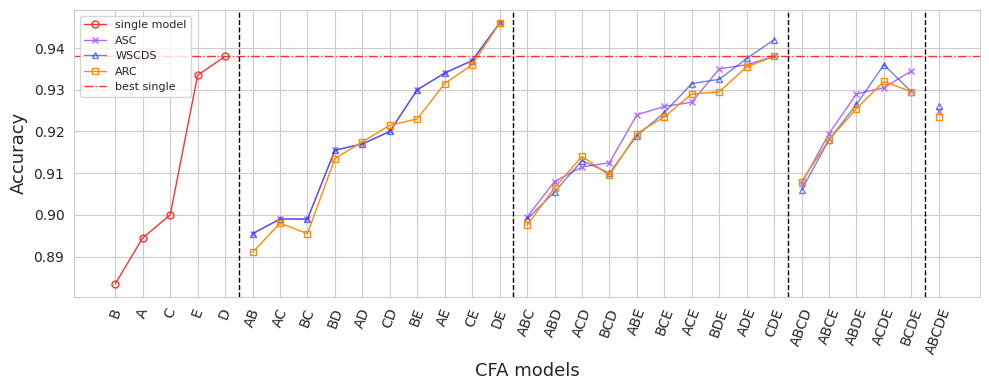

Best combination: 0.9460
Best single: 0.9380


In [ ]:
fusion_df_sorted = performance_plot(
    fusion_df,
    sort_col="asc",
    draw_cols=("asc","wscds"),
    ylabel="Accuracy"
)